# 🧠 Explicabilidade com `dalex` — Breast Cancer Wisconsin (Diagnostic)

Neste notebook mostramos **como o modelo escolhido (LR_L2 com MoreStable12)** toma decisões, usando a biblioteca **[`dalex`](https://dalex.drwhy.ai/)**. A ideia é complementar métricas globais (AUC, AP, Recall) com **explicações globais e locais**, para apoiar auditoria técnica e comunicação com stakeholders não técnicos.

**O que é o `dalex`?**
`dalex` é um toolkit de **explicabilidade de modelos**. Ele cria um objeto `Explainer` (modelo + dados + função de previsão + rótulos) e oferece análises como:

* **Importância de variáveis** (*permutation importance*);
* **Perfis de resposta**: **PDP** (Partial Dependence) e **ALE** (Accumulated Local Effects);
* **Explicações locais**: *breakdown* e **SHAP-like**;
* Diagnósticos (*model performance*) e auditorias (viés, estabilidade, etc.).

> Nota: nosso foco aqui é **interpretar** o comportamento do LR_L2 treinado com **MoreStable12**. Os números de performance continuam no notebook de treinamento.


## 🎯 Objetivos do notebook

1. Construir um `Explainer` do `dalex` para o **pipeline final** (LR_L2).
2. Avaliar **importância de variáveis** e **perfis globais** (PDP/ALE) das 12 features.
3. Gerar **explicações locais** para indivíduos (ex.: casos malignos/limítrofes).
4. Documentar **cautelas** e **boas práticas** ao interpretar esses gráficos.

### 🔎 Nota sobre gráficos: estáticos no GitHub, interativos no notebook

Para que as figuras apareçam corretamente **no GitHub**, optamos por **salvar e exibir imagens estáticas (PNG)** geradas a partir dos gráficos Plotly.
Se você estiver rodando o notebook localmente e quiser **gráficos interativos**, faça o seguinte:


1. Para **ver interativo** no notebook, basta chamar `fig.show()` e, se preferir, **pular a exportação para PNG**:

```python
fig = ...  # figura Plotly gerada (ex.: fig_imp, fig_pdp ou fig_breakdown)
fig.show()  # interativo no Jupyter
# opcional: comentar/omitir pio.write_image(...)
```

2. Para **publicar no GitHub**, mantenha a **exportação para PNG** e a exibição estática:

Instale o backend de exportação (usado quando salvamos PNGs):

```bash
pip install -U kaleido
```

```python
import plotly.io as pio
from IPython.display import Image, display

pio.write_image(fig, "figures/alguma_figura.png", scale=2)  # requer kaleido
display(Image(filename="figures/alguma_figura.png"))
```

> Resumo: **GitHub** só renderiza imagens estáticas; no **Jupyter local**, você pode usar `fig.show()` para manter a interatividade.


## Imports

Esta célula realiza as importações necessárias de bibliotecas Python.

**Biblioteca Dalex** -  **`dalex` (`dx`)**: Para criar explicadores de modelos e realizar análises de interpretabilidade (como importância de variáveis, perfis de dependência parcial e explicações de previsões individuais).

In [1]:
# Imports
import numpy as np
import pandas as pd
import os
from pathlib import Path
import plotly.io as pio
from IPython.display import display, Image, HTML
import joblib
import json
import dalex as dx
from sklearn.model_selection import train_test_split

## 📦 Preparação: artefatos, dados e reprodutibilidade

Nesta seção, carregamos:

* o **pipeline** salvo (`dash_app/models/lr_l2_morestable12.joblib`);
* a lista de **features** na ordem esperada;
* o conjunto de **teste** (ou amostra do conjunto original) para explicabilidade;
* e fixamos a **semente** para reprodutibilidade dos gráficos.

> O `dalex` precisa de uma função de previsão que retorne **probabilidades** da classe positiva (Maligno). Usaremos `pipe.predict_proba(X)[:, 1]`.


## Carregamento de Artefatos e Dados

Esta célula é responsável por carregar os artefatos necessários para a análise e execução do modelo treinado, garantindo a reprodutibilidade e independência de caminhos absolutos.

### Passos Realizados:

1.  **Definição da Raiz do Projeto (`ROOT`)**:
    *   A função `add_project_root` é utilizada para encontrar automaticamente o diretório raiz do projeto, buscando por uma pasta marcadora (por padrão, `src`) até três níveis acima do diretório atual. Isso adiciona o `ROOT` ao `sys.path`, facilitando importações relativas.
2.  **Localização dos Artefatos**:
    *   O caminho para o diretório `models` é definido como `{ROOT}/dash_app/models`.
    *   O código verifica se este diretório existe, lançando um erro caso não seja encontrado.
3.  **Carregamento do Modelo (`pipeline`)**:
    *   O modelo treinado, salvo anteriormente como `lr_l2_morestable12.joblib`, é carregado usando `joblib.load`. Este arquivo contém todo o pipeline de pré-processamento e o classificador.
4.  **Carregamento de Metadados**:
    *   **Ordem das Features (`FEATURE_ORDER`)**: A lista com as 12 features utilizadas pelo modelo é carregada a partir de `feature_order_more_stable_12.json`.
    *   **Ranges das Variáveis (`VARIABLES_RANGE`)**: Os valores mínimos e máximos de cada feature são carregados de `variables_range_more_stable_12.json`. Esses ranges são úteis para simulações e validações.
5.  **Carregamento dos Dados do Dataset**:
    *   O caminho para o arquivo de dados `wdbc.csv` é definido como `{ROOT}/data/wdbc.csv`.
    *   Se o arquivo não existir, o código tenta gerá-lo utilizando uma função específica do projeto (`build_wdbc`). Caso isso falhe, ele recorre ao carregamento direto do dataset `Breast Cancer Wisconsin (Diagnostic)` do `sklearn`, adaptando-o ao formato necessário e salvando como `wdbc.csv`.
    *   Uma vez garantida a existência do arquivo, ele é carregado para um DataFrame (`df`).
6.  **Preparação dos Dados**:
    *   O DataFrame é dividido em `X_full` (features) e `y_full` (rótulos binários: 1 para Maligno, 0 para Benigno).
    *   São selecionadas apenas as features relevantes para o modelo (`X_subset`) e seus respectivos rótulos (`y_subset`).
    *   Os dados são divididos em conjuntos de treino (`X_train`, `y_train`) e teste (`X_test`, `y_test`) para permitir análises e validações subsequentes.

Este processo centraliza o carregamento de todas as dependências necessárias, assegurando que o ambiente esteja corretamente configurado para as análises seguintes.

In [2]:
# Carregar artefatos exportados (com suporte a ROOT)
import sys
from pathlib import Path

# --- Definir/Obter ROOT do projeto ---
def add_project_root(max_up=3, marker='src'):
    p = Path().resolve()
    for _ in range(max_up + 1):
        if (p / marker).exists():
            sys.path.insert(0, str(p))
            return p
        p = p.parent
    raise RuntimeError(f"Não encontrei a pasta '{marker}' nos níveis acima.")

ROOT = add_project_root()

# --- Definir caminho para os modelos em relação ao ROOT ---
models_dir = ROOT / "dash_app" / "models"

# --- Verificar se o diretório existe ---
if not models_dir.exists():
    raise FileNotFoundError(f"O diretório de modelos '{models_dir}' não foi encontrado. Verifique a estrutura do projeto e o valor de ROOT.")

# --- Carregar o modelo treinado ---
model_path = models_dir / "lr_l2_morestable12.joblib"
try:
    pipeline = joblib.load(model_path)
except FileNotFoundError:
    print(f"Erro: Arquivo do modelo não encontrado em {model_path}. Verifique o caminho.")
    # Interrompe a execução se o modelo não for encontrado
    raise SystemExit 

# --- Carregar a ordem das features ---
features_path = models_dir / "feature_order_more_stable_12.json"
try:
    with open(features_path, 'r') as f:
        FEATURE_ORDER = json.load(f)
    print(f"Ordem das features carregada: {FEATURE_ORDER}")
except FileNotFoundError:
    print(f"Erro: Arquivo de ordem das features não encontrado em {features_path}.")
    raise SystemExit

# --- Carregar os ranges das variáveis ---
ranges_path = models_dir / "variables_range_more_stable_12.json"
try:
    with open(ranges_path, 'r') as f:
        VARIABLES_RANGE = json.load(f)
    print("Ranges das variáveis carregados.")
except FileNotFoundError:
    print(f"Erro: Arquivo de ranges das variáveis não encontrado em {ranges_path}.")
    raise SystemExit

# --- Carregar dados reais para contexto (opcional, mas útil) ---
# Importa a função diretamente
from src.data.make_wdbc_dataset import build_wdbc

# Define o caminho para o arquivo de dados
DATA_PATH = ROOT / "data" / "wdbc.csv"

# Garante que o diretório 'data' exista
DATA_PATH.parent.mkdir(parents=True, exist_ok=True)

# Verifica se o arquivo já existe
if not DATA_PATH.exists():
    print(f"Arquivo não encontrado em {DATA_PATH}. Gerando via função build_wdbc...")
    try:
        # Chama a função diretamente
        build_wdbc(DATA_PATH)
        print(f"Arquivo gerado e salvo em {DATA_PATH}")
    except Exception as e:
        print("Falha ao rodar o módulo CLI; gerando via sklearn. Erro:", e)
        from sklearn.datasets import load_breast_cancer
        cancer = load_breast_cancer()
        df_tmp = pd.DataFrame(
            cancer["data"],
            columns=[c.replace(" ", "_") for c in cancer["feature_names"]]
        )
        target = pd.Categorical.from_codes(cancer["target"], cancer["target_names"])
        target = target.rename_categories({"malignant": "Maligno", "benign": "Benigno"})
        df_tmp["diagnosis"] = target.astype(str)
        df_tmp.to_csv(DATA_PATH, index=False)
        print("Gerado e salvo em", DATA_PATH)

# Se chegou até aqui, o arquivo deve existir. Carrega o DataFrame.
df = pd.read_csv(DATA_PATH)

X_full = df.drop(columns=["diagnosis"])
y_full = (df["diagnosis"] == "Maligno").astype(int).to_numpy()

# Selecionar apenas as features do modelo
X_subset = X_full[FEATURE_ORDER]
y_subset = y_full

# Dividir os dados para ter um conjunto de referência
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42, stratify=y_subset)

print(f"Dados de exemplo carregados: {X_train.shape[0]} amostras de treino, {X_test.shape[0]} amostras de teste.")
print(f"Features usadas pelo modelo: {len(FEATURE_ORDER)}")


Ordem das features carregada: ['worst_concavity', 'worst_area', 'worst_texture', 'worst_smoothness', 'mean_concave_points', 'area_error', 'mean_compactness', 'compactness_error', 'symmetry_error', 'worst_symmetry', 'texture_error', 'concave_points_error']
Ranges das variáveis carregados.
Dados de exemplo carregados: 455 amostras de treino, 114 amostras de teste.
Features usadas pelo modelo: 12


## Seleção de Amostras Representativas para Análise Breakdown

Esta célula tem como objetivo identificar ou gerar um conjunto diversificado de amostras do conjunto de dados de treinamento (`X_train`) para serem utilizadas posteriormente nas análises de explicabilidade `breakdown` com o `dalex`. O critério para a seleção é obter amostras cujas probabilidades preditas de serem malignas (`proba_malignant`) sejam próximas a valores-alvo específicos: 0.0, 0.2, 0.4, 0.6, 0.8 e 1.0.

### Passo a Passo:

1.  **Previsão no Conjunto de Treino**:
    *   O modelo treinado (`pipeline`) é usado para prever as probabilidades (`proba_train`) e classes (`pred_train`) para todas as amostras do conjunto de treino (`X_train`).
    *   Um novo DataFrame, `train_proba_df`, é criado contendo as features originais, a probabilidade predita e a classe predita.

2.  **Funções Auxiliares**:
    *   `pick_closest(target, probs, used)`:
        *   Encontra o índice da amostra em `probs` (probabilidades preditas) cujo valor é o mais próximo do `target`, excluindo índices já utilizados (`used`).
        *   Retorna o índice e a distância absoluta entre a probabilidade encontrada e o alvo.
    *   `interpolate_to_target(...)`:
        *   Tenta criar uma amostra sintética cuja probabilidade predita seja próxima do `target`.
        *   Faz isso interpolando entre duas amostras do treino: uma com probabilidade abaixo do alvo (`x_low`) e outra com probabilidade acima (`x_high`).
        *   Utiliza um método de bisseção para encontrar uma combinação linear das duas amostras que resulte na probabilidade desejada, dentro de uma tolerância (`tol`).
        *   Retorna os valores da nova amostra sintética e a probabilidade alcançada.

3.  **Seleção das Amostras Alvo**:
    *   Define os rótulos e valores-alvo desejados (`targets`): `pmin` (0.0), `p_0.20` (0.20), ..., `pmax` (1.00).
    *   **Extremos (`pmin` e `pmax`)**:
        *   As amostras reais com as probabilidades preditas mínima e máxima são selecionadas diretamente do conjunto de treino.
    *   **Valores Intermediários (`p_0.20` a `p_0.80`)**:
        *   **Busca Direta**: Primeiro, tenta encontrar uma amostra real no treino cuja probabilidade esteja dentro de uma tolerância (`ok_eps = 0.03`) do valor alvo.
        *   **Interpolação Sintética**: Se não encontrar uma amostra real suficientemente próxima, tenta criar uma amostra sintética interpolando entre a amostra real com a maior probabilidade abaixo do alvo e a com a menor probabilidade acima do alvo.
        *   **Último Recurso**: Se a interpolação falhar ou não for possível, seleciona a amostra real com a probabilidade mais próxima do alvo, mesmo que a distância seja maior que a tolerância.

4.  **Consolidação dos Resultados**:
    *   As amostras selecionadas (reais ou sintéticas) são combinadas em um único DataFrame (`selected_df`).
    *   Informações sobre cada amostra (rótulo, probabilidade alvo, probabilidade alcançada, origem, índice no treino) são armazenadas em `meta_df`.
    *   Um dicionário (`obs_for_breakdown`) é criado para facilitar o acesso às amostras individuais posteriormente. Por exemplo, `obs_for_breakdown["p_0.60"]` retorna um DataFrame com uma única linha contendo os valores das features da amostra selecionada para o alvo 0.60.

### Resultado:

Ao final da execução, a célula imprime um resumo das amostras selecionadas, mostrando seu rótulo, a probabilidade alvo, a probabilidade efetivamente alcançada, a origem (real do treino, interpolada sintética ou a mais próxima real) e o índice original no conjunto de treino (se aplicável). Isso garante um conjunto diversificado de casos para análise detalhada do modelo.

In [3]:
# Seleciona/gera amostras representativas
from collections import OrderedDict

# 1) Prever no treino inteiro
X_train_ordered = X_train[FEATURE_ORDER].copy()
proba_train = pipeline.predict_proba(X_train_ordered)[:, 1]
pred_train = (proba_train >= 0.5).astype(int)

train_proba_df = X_train_ordered.copy()
train_proba_df["proba_malignant"] = proba_train
train_proba_df["pred_class"] = pred_train

print(f"Treino: {len(train_proba_df)} linhas, {len(FEATURE_ORDER)} features.")
print("Faixa de probabilidades no treino:",
      f"min={proba_train.min():.4f}  max={proba_train.max():.4f}")

# ---------- Auxiliares ----------
def pick_closest(target, probs, used=None):
    """Retorna índice do elemento de probs mais próximo de target, ignorando used."""
    used = used or set()
    mask = np.ones_like(probs, dtype=bool)
    if used:
        mask[list(used)] = False
    if not mask.any():
        return None, None
    cand_idx = np.where(mask)[0]
    i = cand_idx[np.argmin(np.abs(probs[mask] - target))]
    return int(i), float(abs(probs[i] - target))

def interpolate_to_target(x_low, p_low, x_high, p_high, target,
                          tol=1e-3, max_iter=40):
    """
    Interpola no segmento [x_low, x_high] procurando probabilidade ~ target.
    Usa bisseção no alfa do segmento; requer p_low < target < p_high (ou vice-versa).
    """
    # Garante ordem: p_low < target < p_high
    if not (p_low < target < p_high or p_high < target < p_low):
        return None, None
    # Coloca de forma que p_a < target < p_b
    if p_low < p_high:
        x_a, p_a, x_b, p_b = x_low, p_low, x_high, p_high
    else:
        x_a, p_a, x_b, p_b = x_high, p_high, x_low, p_low

    a, b = 0.0, 1.0
    x_a = x_a.astype(float); x_b = x_b.astype(float)
    for _ in range(max_iter):
        m = 0.5 * (a + b)
        x_m = (1 - m) * x_a + m * x_b
        p_m = pipeline.predict_proba(pd.DataFrame([x_m], columns=FEATURE_ORDER))[:, 1][0]
        if abs(p_m - target) <= tol:
            return x_m, float(p_m)
        if p_m < target:
            a, x_a, p_a = m, x_m, p_m
        else:
            b, x_b, p_b = m, x_m, p_m
    return x_m, float(p_m)  # retorna melhor aproximação

# 2) Seleções alvo
targets = OrderedDict([
    ("pmin", 0.00),
    ("p_0.20", 0.20),
    ("p_0.40", 0.40),
    ("p_0.60", 0.60),
    ("p_0.80", 0.80),
    ("pmax", 1.00),
])

used = set()
rows = []      # lista de DataFrames 1-linha com as features
metas = []     # metadados por linha
ok_eps = 0.03  # tolerância para considerar "encontrado no treino"

# extremos (sempre do treino)
i_min = int(np.argmin(proba_train))
i_max = int(np.argmax(proba_train))
for label, idx, tgt in [("pmin", i_min, 0.0), ("pmax", i_max, 1.0)]:
    used.add(idx)
    rows.append(train_proba_df.iloc[[idx]][FEATURE_ORDER])
    metas.append(dict(label=label, source="train", target=tgt,
                      pred=float(proba_train[idx]),
                      train_index=int(train_proba_df.index[idx])))

# metas intermediárias
for label, tgt in [("p_0.20", 0.20), ("p_0.40", 0.40),
                   ("p_0.60", 0.60), ("p_0.80", 0.80)]:
    idx, dist = pick_closest(tgt, proba_train, used)
    if idx is not None and dist <= ok_eps:
        used.add(idx)
        rows.append(train_proba_df.iloc[[idx]][FEATURE_ORDER])
        metas.append(dict(label=label, source="train",
                          target=tgt, pred=float(proba_train[idx]),
                          train_index=int(train_proba_df.index[idx])))
        continue

    # Tentar sintetizar por interpolação entre um ponto abaixo e um acima
    below_idx = np.where(proba_train < tgt)[0]
    above_idx = np.where(proba_train > tgt)[0]
    if len(below_idx) and len(above_idx):
        i_low  = below_idx[np.argmax(proba_train[below_idx])]   # maior abaixo
        i_high = above_idx[np.argmin(proba_train[above_idx])]   # menor acima
        x_low  = train_proba_df.iloc[i_low][FEATURE_ORDER].to_numpy()
        x_high = train_proba_df.iloc[i_high][FEATURE_ORDER].to_numpy()

        x_syn, p_syn = interpolate_to_target(
            x_low, proba_train[i_low], x_high, proba_train[i_high],
            target=tgt, tol=1e-3, max_iter=40
        )
        if x_syn is not None:
            row = pd.DataFrame([x_syn], columns=FEATURE_ORDER)
            rows.append(row)
            metas.append(dict(label=label, source="synthetic",
                              target=tgt, pred=float(p_syn),
                              train_index=None))
            continue

    # Último fallback: pega o mais próximo disponível (mesmo que distante)
    if idx is None:
        idx = int(np.argmin(np.abs(proba_train - tgt)))
    used.add(idx)
    rows.append(train_proba_df.iloc[[idx]][FEATURE_ORDER])
    metas.append(dict(label=label, source="train_nearest",
                      target=tgt, pred=float(proba_train[idx]),
                      train_index=int(train_proba_df.index[idx])))

# 3) Consolidar selecionados para uso no breakdown
selected_df = pd.concat(rows, ignore_index=True)
meta_df = pd.DataFrame(metas)
selected_df.insert(0, "selection_label", meta_df["label"])
selected_df["target_p"] = meta_df["target"].values
selected_df["achieved_p"] = meta_df["pred"].values
selected_df["source"] = meta_df["source"].values
selected_df["train_index"] = meta_df["train_index"].values

# Dicionário pronto para usar com dalex: obs_for_breakdown["p_0.60"] -> DataFrame 1 linha com FEATURES
obs_for_breakdown = {
    lbl: selected_df[selected_df["selection_label"] == lbl][FEATURE_ORDER]
    for lbl in selected_df["selection_label"]
}

print("\nSelecionadas para breakdown:")
print(selected_df[["selection_label", "target_p", "achieved_p", "source", "train_index"]])


Treino: 455 linhas, 12 features.
Faixa de probabilidades no treino: min=0.0000  max=1.0000

Selecionadas para breakdown:
  selection_label  target_p    achieved_p source  train_index
0            pmin       0.0  2.993316e-14  train          101
1            pmax       1.0  1.000000e+00  train          265
2          p_0.20       0.2  1.763068e-01  train           89
3          p_0.40       0.4  3.809545e-01  train           40
4          p_0.60       0.6  5.976898e-01  train          215
5          p_0.80       0.8  8.064941e-01  train          542


## 🔌 Criando o `Explainer` (`dalex.Explainer`)

Aqui instanciamos o `Explainer`, informando:

* `model`: o pipeline scikit-learn já treinado;
* `data`: um `DataFrame` com as **12 variáveis** (sem a coluna-alvo);
* `y`: vetor `0/1` (0=Benigno, 1=Maligno);
* `predict_function`: função que devolve **probabilidade de Maligno**;
* `label`: rótulo amigável do modelo (“LR_L2 — MoreStable12”).

In [4]:
# Criar Explainer com Dalex (usando dados reais de treino)

# Definir uma função de predição nomeada
def predict_proba_positive_class(model, X):
    """Função para obter a probabilidade da classe positiva (1)."""
    return model.predict_proba(X)[:, 1]

try:
    # Reordenar X_train para garantir a ordem correta
    X_train_ordered = X_train[FEATURE_ORDER]

    # Criar o explainer usando o pipeline carregado e os dados reais de treino
    explainer = dx.Explainer(
        model=pipeline,
        data=X_train_ordered, # Já ordenado
        y=y_train,
        predict_function=predict_proba_positive_class, # Função nomeada
        label="LR_L2"
    )

    print("Explainer Dalex criado com sucesso usando dados reais de treino.")
except Exception as e:
    print(f"Erro ao criar explainer: {e}")
    raise

Preparation of a new explainer is initiated

  -> data              : 455 rows 12 cols
  -> target variable   : 455 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : LR_L2
  -> predict function  : <function predict_proba_positive_class at 0x7cc33d191cf0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 2.99e-14, mean = 0.381, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.806, mean = -0.00779, max = 0.956
  -> model_info        : package sklearn

A new explainer has been created!
Explainer Dalex criado com sucesso usando dados reais de treino.


## 🌎 Importância de variáveis (Permutation Importance)

Aqui calculamos a **importância via permutação**: embaralhamos uma feature por vez, medimos o **quanto o desempenho cai** (por ex., *loss* baseada em log-loss/auc), e ordenamos do **maior impacto** para o **menor**.

**Leitura**:

* Maior queda de desempenho ⇒ **maior importância**.
* Em geral casa bem com a magnitude dos **coeficientes** no LR_L2, mas **não é idêntico**: permutação captura **efeitos globais** em conjunto com correlações restantes.

Calculando importância das variáveis...


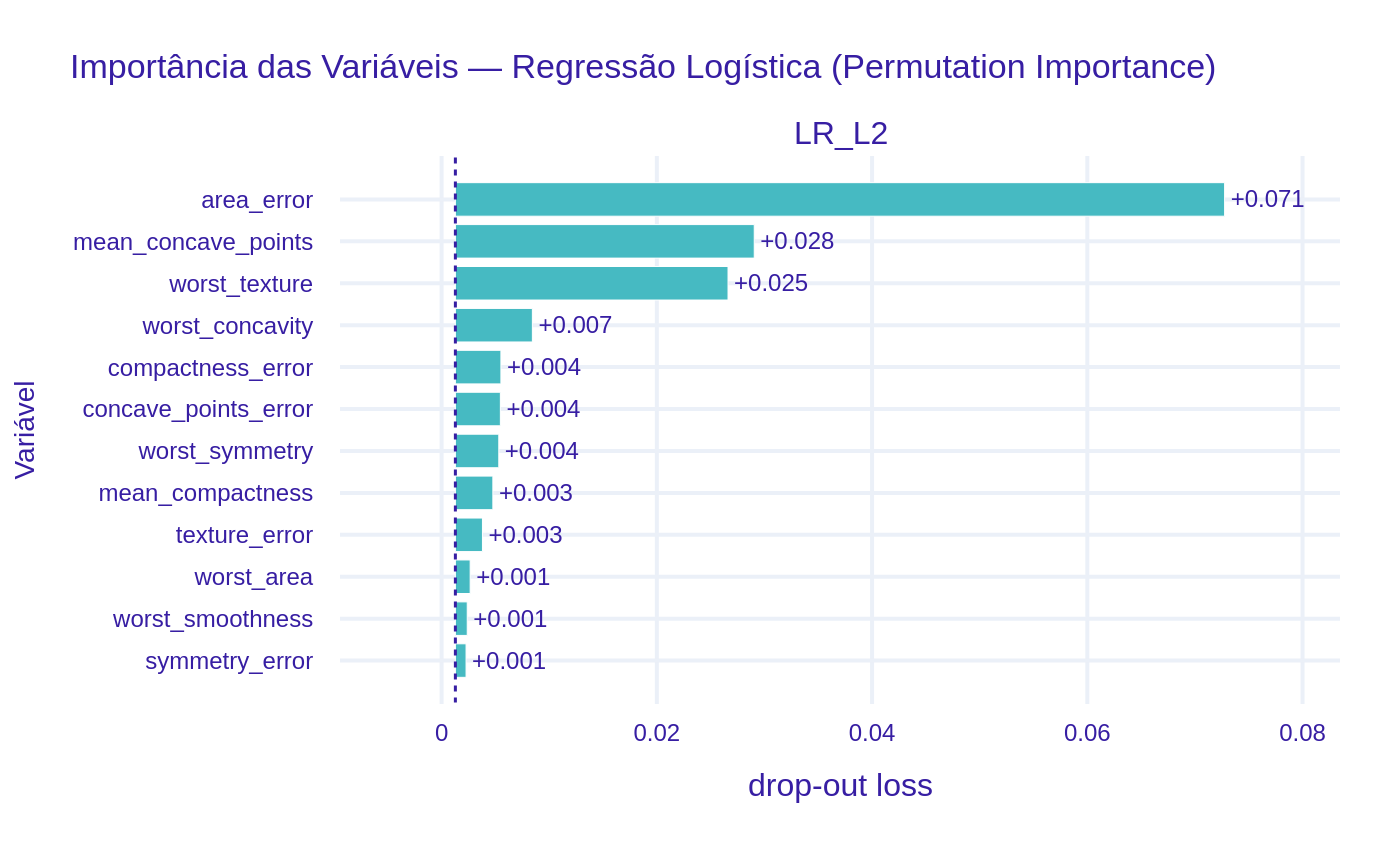

In [5]:
# Análise de Importância de Variáveis

# pastas de saída
fig_dir = Path("figures")
fig_dir.mkdir(parents=True, exist_ok=True)
png_path = fig_dir / "var_importance_lr_l2.png"

try:
    print("Calculando importância das variáveis...")

    # Para pipelines com pré-processamento, 'random' é mais robusto que 'permute'
    variable_importance = explainer.model_parts(
        depend_method="random",
        N=100,
        variables=None
    )

    if variable_importance.result.empty:
        raise ValueError("O cálculo de importância retornou um resultado vazio.")

    # Figura plotly (não mostrar ainda para poder salvar)
    fig_imp = variable_importance.plot(max_vars=12, show=False)
    fig_imp.update_layout(
        title="Importância das Variáveis — Regressão Logística (Permutation Importance)",
        yaxis_title="Variável",
        template="plotly_white"
    )

    # Salvar PNG estático (para GitHub)
    try:
        pio.write_image(fig_imp, str(png_path), scale=2)  # requer 'pip install -U kaleido'
        display(Image(filename=str(png_path)))
    except Exception as e_img:
        print(f"Aviso: não foi possível salvar/mostrar PNG com kaleido ({type(e_img).__name__}: {e_img}).")
        print("Instale com: pip install -U kaleido")

except Exception as e:
    print(f"Erro ao calcular ou plotar a importância das variáveis: {e}")
    print(f"Tipo do erro: {type(e).__name__}")


### 📊 Permutation Importance vs. Coeficientes da Regressão Logística

Os **coeficientes (LR_L2)** e a **Permutation Importance (PI)** respondem a perguntas diferentes — por isso as ordens podem divergir mesmo quando apontam para as mesmas variáveis "de topo".

**O que cada uma mede**

* **Coeficientes (|β|)**: efeito **linear** de **1 unidade** (na escala após *preprocess* — Yeo-Johnson) na **log-odds** de "Maligno", **mantendo as demais variáveis fixas**.

  * Bons para **direção do efeito** (sinal +/–) e para entender a **forma funcional** assumida pelo modelo.
* **Permutation Importance**: **queda de desempenho** (ex.: AUC/AP) quando embaralhamos os valores de uma variável **depois do pipeline**.

  * Mede o **impacto prático/global** dessa variável na **qualidade preditiva** do modelo.

**Por que os rankings podem diferir?**

1. **Colinearidade / compartilhamento de informação**
   Variáveis correlacionadas podem ter coeficientes altos, mas a PI "divide" o crédito: ao embaralhar uma, as outras ainda carregam parte do sinal → a queda de AUC é menor.

2. **Métrica de avaliação**
   A PI depende da **métrica escolhida** (AUC, AP, etc.) e do **nível de ruído** do *holdout* usado. Coeficientes não mudam com a métrica.

3. **Regularização**
   A LR_L2 **encolhe** coeficientes (mais ou menos dependendo de `C`). Uma variável útil pode ter |β| moderado e ainda assim gerar **grande perda de AUC** quando permutada.

4. **Transformações no *preprocess***
   Yeo-Johnson e mudam a **simetria**; |β| passa a refletir efeito **na variável transformada**. A PI, por sua vez, mede o impacto **após todo o pipeline** (modelo-agnóstica).

5. **Efeito conjunto vs. marginal**
   Coeficientes são **condicionais** (mantendo o resto fixo). A PI é uma medida **global** do que acontece quando quebramos a **associação natural** daquela variável com as demais.


## 📈 Perfis de resposta — PDP e ALE

Nesta seção geramos **perfis globais** de uma variável por vez:

* **PDP (Partial Dependence)**: média das previsões enquanto **mantém as demais variáveis fixas**. Fácil de ler, porém pode distorcer quando há **correlações fortes** entre features.
* **ALE (Accumulated Local Effects)**: foca em **efeitos locais** por janelas e integra os efeitos parciais. É **mais estável** quando há correlação entre preditores.

**Como ler**:

* Eixo x: valores da variável (na escala original do pipeline de entrada).
* Eixo y: mudança na **probabilidade prevista** (ou no *link* interno), mantendo o restante como observado.

> **Nota sobre a escolha do PDP**: Optamos por utilizar os perfis PDP nesta análise porque as 12 features selecionadas para o modelo passaram por um processo de poda (*pruning*) baseado na correlação. Esse procedimento de seleção reduziu significativamente a multicolinearidade entre as variáveis, mitigando um dos principais problemas do PDP. Dessa forma, os perfis PDP refletem de maneira mais fiel a relação entre cada variável e a predição do modelo.

Top-4 features: ['area_error', 'mean_concave_points', 'worst_texture', 'worst_concavity']


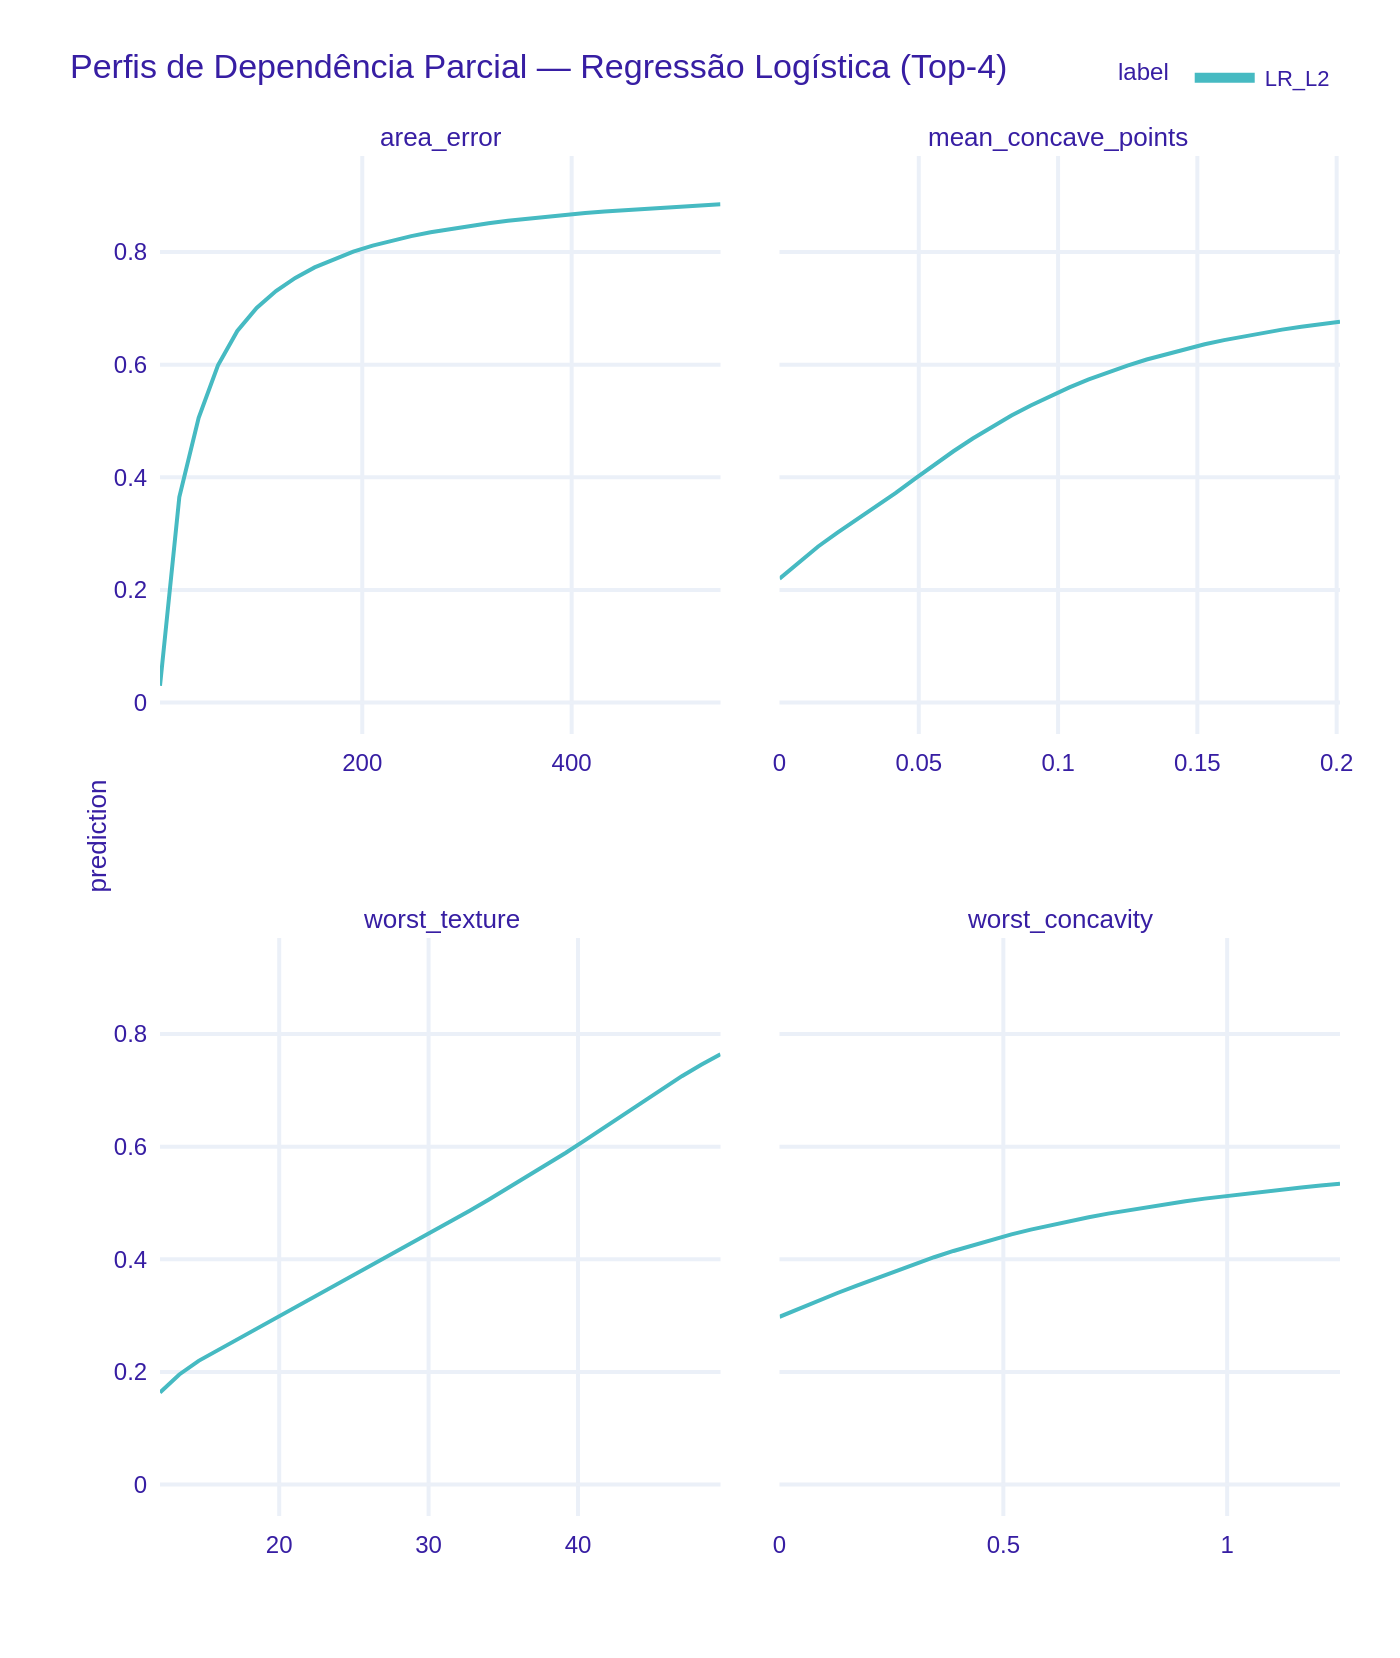

In [6]:
# --- Perfil de Dependência Parcial (Partial Dependence Profile) ---

# Pasta de saída
fig_dir = Path("figures")
fig_dir.mkdir(parents=True, exist_ok=True)
png_pdp_path = fig_dir / "pdp_lr_l2_top4.png"

# Seleciona Top-4 features pela importância por permutação (já calculada)
vi = variable_importance.result.copy()
top_features = (
    vi[vi["variable"] != "_baseline_"]
      .groupby("variable")["dropout_loss"].mean()
      .sort_values(ascending=False)
      .head(4)
      .index.tolist()
)
print("Top-4 features:", top_features)

# Calcula PDP (ou troque 'type' para "accumulated" se preferir ALE)
pdp = explainer.model_profile(
    type="partial",       # "partial" (PDP) | "accumulated" (ALE)
    variables=top_features,
    N=300,
    grid_points=30,
    verbose=False
)

# Gera figura Plotly SEM exibir
fig_pdp = pdp.plot(variables=top_features, show=False)
fig_pdp.update_layout(
    title="Perfis de Dependência Parcial — Regressão Logística (Top-4)",
    template="plotly_white"
)

# Salva PNG estático e exibe a imagem
try:
    pio.write_image(fig_pdp, str(png_pdp_path), scale=2)  # requer: pip install -U kaleido
    display(Image(filename=str(png_pdp_path)))
except Exception as e_img:
    print(f"Aviso: não foi possível salvar/mostrar PNG (kaleido): {type(e_img).__name__}: {e_img}")
    print("Instale com: pip install -U kaleido")


Este gráfico apresenta **perfis de dependência parcial (PDP)** para quatro variáveis do modelo de Regressão Logística. O PDP mostra como a **probabilidade predita** de uma observação ser classificada como maligna muda quando o valor de uma única variável é alterado, mantendo todas as demais variáveis fixas na média.

Vamos interpretar cada um dos perfis:

### 1. `area_error`
  Crescimento **rápido** no início (0 → ~100), depois **satura**. Pequenos aumentos no baixo/medio intervalo já elevam bastante o risco; acima de ~200 o ganho é **marginal** (efeito de **retorno decrescente**). Interpretação: irregularidade/variabilidade de área maior → maior probabilidade de malignidade, com **curva monotônica e côncava**.

### 2. `worst_texture`
  Relação **quase linear e crescente** em toda a faixa (~13–49). Cada incremento na textura "pior caso" aumenta o risco de forma **constante** (sem platô visível). Sinal claro de que textura no pior cenário é um **driver estável** da probabilidade.

### 3. `mean_concave_points`
  Crescente com **forte inclinação** até ~0.10, depois **abranda** (novo platô acima de ~0.15). Ou seja, pequenas elevações na densidade média de pontos côncavos já impactam muito; acima de ~0.10 o efeito **continua**, mas com **menor ganho marginal**.

### 4. `worst_concavity`
  Crescente e **mais suave** que as anteriores; não há ponto de inflexão marcado, mas a inclinação **reduz levemente** em valores altos. Indica que concavidade no pior caso aumenta o risco, porém com **efeito marginal moderado** e **gradual**.

Em conjunto, os PDPs sugerem:

* **Monotonicidade positiva** para as quatro variáveis (mais "erro/irregularidade/concavidade/textura" → maior probabilidade de Maligno).
* **Saturação** clara em **area_error** e **mean_concave_points** (boas candidatas a efeitos não lineares capturados pelo Yeo–Johnson).
* **worst_texture** se destaca por **linearidade** (efeito consistente em toda a faixa).
* **worst_concavity** contribui, mas com **inclinação menor**, reforçando seu papel como variável de apoio ao conjunto.


## 🔍 Explicações locais — *Breakdown* e SHAP-like

Agora olhamos **um indivíduo específico** (linha do conjunto de teste):

* **Breakdown**: decompõe a **previsão individual** em **contribuições por variável**, mostrando como partimos de uma **probabilidade base** até chegar na **probabilidade final**.
* **SHAP (aprox.)**: distribui a contribuição de forma **axiomática** (Shapley), considerando **todas as coalizões**; é mais caro, mas amplamente utilizado.

**Como escolher a observação**:

* Caso **verdadeiro Maligno** corretamente detectado;
* Caso **Benigno**;
* Um caso **limítrofe** (probabilidade perto do limiar), se existir — muito didático.


## Gráfico Breakdown

Este código define uma função `plot_breakdown_from_bd` que cria um gráfico de barras horizontais em estilo **Waterfall** utilizando a biblioteca `plotly.graph_objects`. O objetivo é visualizar de forma clara e detalhada como um modelo preditivo chega a uma determinada previsão para uma observação específica, decompondo a contribuição de cada variável.

### Como funciona o gráfico:

1.  **Estrutura Waterfall**:
    *   Cada barra horizontal representa a **contribuição (`contribution` ou Δ)** de uma variável (ou do intercepto) para a previsão final.
    *   As barras são empilhadas horizontalmente, mostrando como a previsão evolui do **intercepto** (valor base) até a **predição final**.
2.  **Elementos Chave**:
    *   **Intercepto**: A primeira barra (na base) mostra o valor base da previsão do modelo antes de considerar qualquer característica da observação. Uma **linha vertical tracejada cinza** marca exatamente esse valor no eixo X para facilitar a referência.
    *   **Variáveis**: As barras subsequentes mostram o impacto de cada variável. Barras para a **direita** indicam contribuição positiva (aumentam a probabilidade), enquanto barras para a **esquerda** indicam contribuição negativa (diminuem a probabilidade).
    *   **Predição Final**: A última barra (no topo) representa a previsão final do modelo para aquela observação.
3.  **Personalização e Controle**:
    *   **Rótulos**: Os rótulos no eixo Y já vêm formatados pelo `dalex` (ex: `worst_concavity = 0.4636`), evitando duplicações.
    *   **Hover Personalizado**: Ao passar o mouse sobre uma barra, um tooltip mostra informações detalhadas:
        *   Nome da variável e seu valor.
        *   `contribution (Δ)`: A contribuição exata dessa variável.
        *   `cum. before`: A probabilidade acumulada *antes* de considerar essa variável.
        *   `cum. after`: A probabilidade acumulada *depois* de considerar essa variável.
    *   **Ordem Fixa**: O gráfico garante que o intercepto esteja sempre na base e a predição final no topo, respeitando a lógica da decomposição.
    *   **Cores**: Cores distintas para contribuições positivas (vermelho/crimson) e negativas (verde/seagreen), com a predição final em azul (royalblue).

### Por que um código personalizado?

Optamos por desenvolver este gráfico personalizado ao invés de utilizar diretamente a visualização padrão disponível no pacote `dalex` porque desejávamos **maior controle e personalização**, especialmente em relação às informações exibidas no **tooltip (hover)**. Esta versão nos permite mostrar de forma clara e precisa os valores cumulativos antes e depois de cada contribuição, o que é crucial para a interpretação detalhada do modelo.

Este gráfico será integrado ao **dashboard do projeto**, proporcionando uma visualização interativa e informativa para análise de previsões individuais do modelo.

In [7]:
# Gráfico Breakdown
import plotly.graph_objects as go

def plot_breakdown_from_bd(bd, title=None):
    """
    Waterfall horizontal a partir de bd.result (dalex predict_parts),
    com:
      - contribution (Δ) e cumulative (antes/depois) no hover via customdata
      - intercept no topo e prediction embaixo
      - rótulos prontos (sem duplicação)
    """
    res = bd.result.copy()

    # rótulos prontos (do dalex)
    labels = res["variable"].astype(str).tolist()

    # números
    contrib     = res["contribution"].astype(float).to_numpy()  # Δ (o que desejamos mostrar)
    cum_after   = res["cumulative"].astype(float).to_numpy()    # acumulado após o passo
    cum_before  = cum_after - contrib                           # acumulado antes do passo

    # intercept é o 1º; prediction é o último -> manter essa ordem e fixá-la no eixo
    # Medidas: todos 'relative' e o último 'total'
    measure = ["relative"] * len(res)
    if measure:
        measure[-1] = "total"

    # Linha tracejada na posição do intercept (acumulado após o 1º passo)
    intercept_x = cum_after[0] if len(cum_after) else 0.0

    # --- construir figura ---
    fig = go.Figure()

    fig.add_shape(
        type="line",
        x0=intercept_x, x1=intercept_x, y0=0, y1=1, yref="paper",
        line=dict(color="rgb(90,90,90)", width=1.5, dash="dot"), layer="below"
    )

    # customdata com as 3 coisas que queremos no hover: Δ, cum_before, cum_after
    customdata = np.stack([contrib, cum_before, cum_after], axis=1)

    fig.add_trace(go.Waterfall(
        orientation="h",
        measure=measure,
        y=labels,
        x=contrib,                         # passa o Δ como 'x'; no hover NÃO usaremos %{x}
        text=[f"{c:+.3f}" for c in contrib],
        textposition="outside",
        customdata=customdata,
        hovertemplate=(
            "%{y}"
            "<br>contribution (Δ): %{customdata[0]:.3f}"
            "<br>cum. before: %{customdata[1]:.3f}"
            "<br>cum. after: %{customdata[2]:.3f}"
            "<extra></extra>"
        ),
        connector=dict(line=dict(color="rgb(90,90,90)")),
        decreasing=dict(marker=dict(color="seagreen")),
        increasing=dict(marker=dict(color="crimson")),
        totals=dict(marker=dict(color="royalblue")),
    ))

    # Garantir ordem visual: intercept (linha 0) no topo, prediction (última) embaixo
    fig.update_yaxes(categoryorder="array", categoryarray=labels)

    fig.update_layout(
        title=title or "Breakdown",
        showlegend=False,
        xaxis_title="contribution",
        hovermode="closest",
        margin=dict(t=70, b=40, l=10, r=10),
        template="plotly_white",
    )
    return fig

### 🔎 Breakdown (DALEx) — como vamos ler as **6 amostras**

Nesta seção usamos o **Break Down** do **DALEx** para explicar, **amostra a amostra**, como o *pipeline* **LR L2 + MoreStable12** chega à probabilidade final. Cada gráfico mostra um “**caminho de contribuições**”: começamos no **intercepto** do modelo e somamos os efeitos das variáveis (barras) até chegar à **previsão** daquela observação.

**Como interpretar rapidamente**

* Barras **vermelhas**: aumentam a probabilidade de **Maligno** (contribuições positivas).
* Barras **verdes**: reduzem a probabilidade (contribuições negativas).
* O eixo horizontal é a **probabilidade cumulativa** após cada passo.
* A ordem das barras reflete a **decomposição local** para a observação (não é um ranking global).

**Amostras analisadas**
Selecionamos seis casos para cobrir diferentes regiões do espaço de probabilidade: **pmin (~0)**, **p_0.20**, **p_0.40**, **p_0.60**, **p_0.80** e **pmax (~1.0)**.


**O que observar nos gráficos**

* Quais variáveis **puxam para cima/baixo** a previsão e **quanto** (magnitude da barra).
* Coerência qualitativa com os **coeficientes da LR** (sinal esperado) e com os **gráficos globais** (Permutation Importance, PDPs).
* **Saturações**: quando a probabilidade já está muito alta/baixa, novas contribuições tendem a ter **efeito residual**.

A seguir, apresentamos os seis gráficos (um por amostra) com comentários curtos e focados no que realmente move a decisão do modelo em cada caso.


                       variable variable_value  contribution    cumulative
0                     intercept                 3.814162e-01  3.814162e-01
1   compactness_error = 0.01084        0.01084  5.026219e-02  4.316784e-01
2     worst_smoothness = 0.1584         0.1584  2.684975e-02  4.585282e-01
3    mean_compactness = 0.07568        0.07568  1.893783e-02  4.774660e-01
4       worst_symmetry = 0.2932         0.2932  1.882573e-02  4.962917e-01
5         texture_error = 1.508          1.508 -2.237566e-02  4.739161e-01
6      symmetry_error = 0.02659        0.02659 -2.343634e-02  4.504798e-01
7         worst_concavity = 0.0            0.0 -8.948160e-02  3.609981e-01
8            worst_area = 185.2          185.2 -1.028565e-01  2.581416e-01
9         worst_texture = 19.54          19.54 -1.291136e-01  1.290280e-01
10   concave_points_error = 0.0            0.0 -1.170937e-01  1.193431e-02
11    mean_concave_points = 0.0            0.0 -1.193411e-02  1.956204e-07
12           area_error =

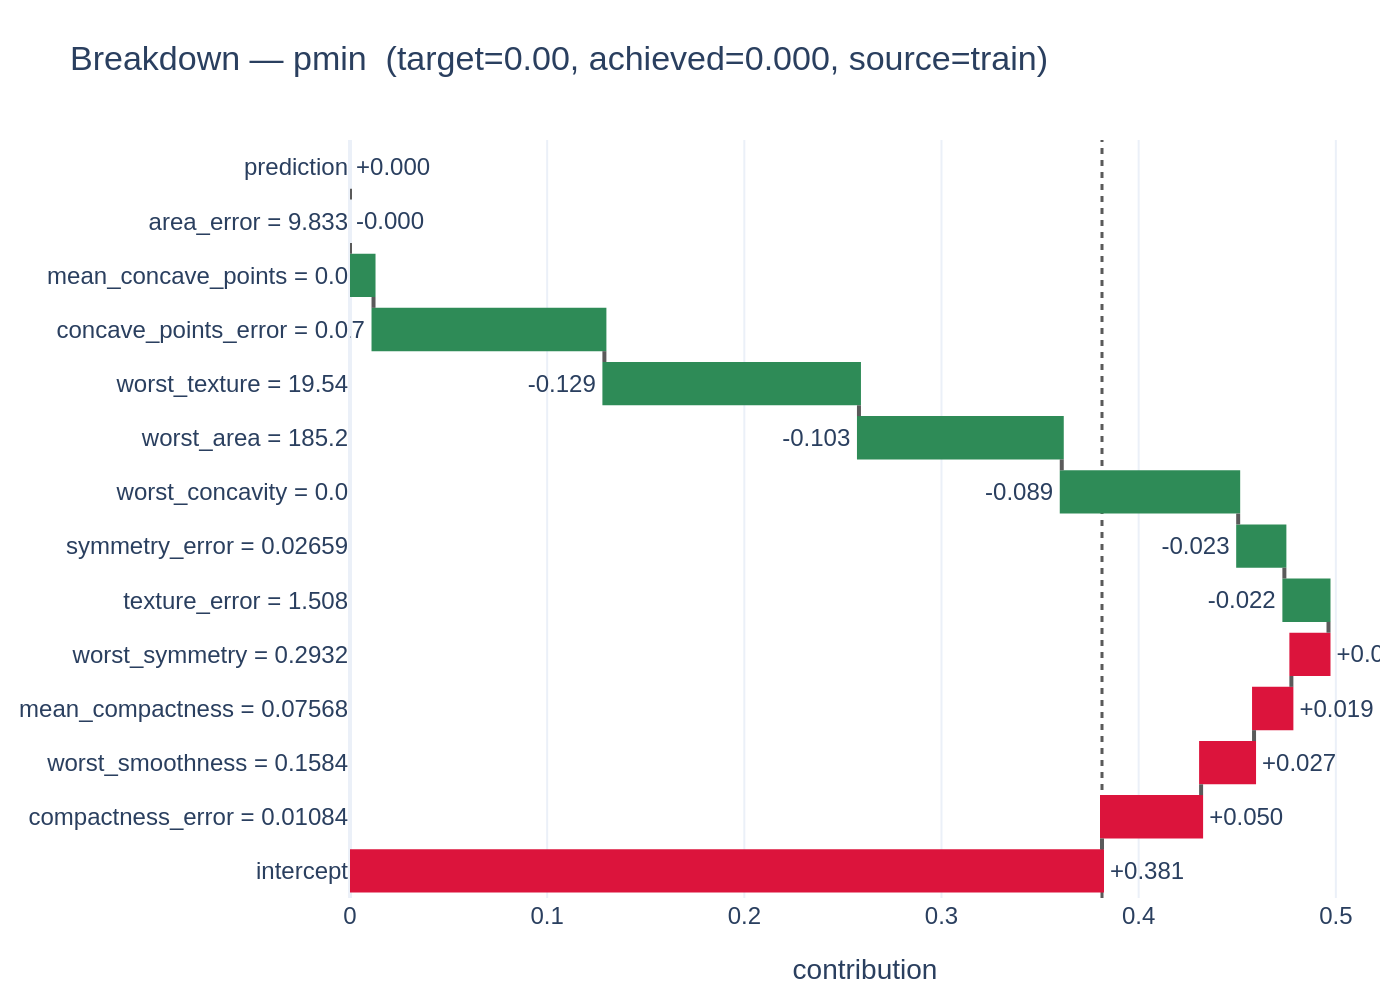

In [8]:
# Break Down: prob ≈ 0.00 (pmin)
label = "pmin"
obs   = obs_for_breakdown[label]
bd    = explainer.predict_parts(new_observation=obs, type="break_down", keep_distributions=True)

meta  = selected_df[selected_df["selection_label"] == label].iloc[0]
title = (f"Breakdown — {label}  (target={meta['target_p']:.2f}, "
         f"achieved={meta['achieved_p']:.3f}, source={meta['source']})")

print(bd.result[["variable","variable_value","contribution","cumulative"]])

# Gera figura (sem exibir interativo)
fig = plot_breakdown_from_bd(bd, title=title)

# Caminho e pasta de saída
fig_dir = Path("figures")
fig_dir.mkdir(parents=True, exist_ok=True)
png_path = fig_dir / f"breakdown_{label}.png"

# Salva PNG estático e exibe no notebook
try:
    pio.write_image(fig, str(png_path), scale=2)  # precisa do pacote 'kaleido'
    display(Image(filename=str(png_path)))
except Exception as e_img:
    print(f"Aviso: não foi possível salvar/mostrar PNG (kaleido): {type(e_img).__name__}: {e_img}")
    print("Instale com: pip install -U kaleido")


### 🔍 Breakdown — amostra **p_min** (prob. prevista ≈ **0,00**)

Vamos interpretar o gráfico de **Breakdown** para a amostra **pmin** (aquela com **probabilidade prevista ≈ 0**). O gráfico mostra um "**caminho de contribuições**" (waterfall) que parte do **intercepto** e soma os efeitos de cada variável até chegar à probabilidade final.

### Como ler

* **Barra vermelha (intercept)**: ponto de partida do modelo (**~0,381**).
* **Barras verdes**: **diminuem** a probabilidade final (empurram para Benigno).
* **Barras vermelhas**: **aumentam** a probabilidade (empurram para Maligno).
* O eixo x mostra a **probabilidade cumulativa** após cada passo.

### Passo a passo (principais destaques)

1. **Intercepto ~ 0,381 → 0,432**
   Pequenos **empurrões para cima** (malignidade) vindos de:

   * `compactness_error = 0.01084` (+0,050)
   * `worst_smoothness = 0.1584` (+0,027)
   * `mean_compactness = 0.07568` (+0,019)
   * `worst_symmetry = 0.2932` (+0,019)
     Esses valores, um pouco mais altos, **puxam levemente** para Maligno.

2. **Virada para baixo (predomínio de sinais de benignidade)**
   Em seguida aparecem efeitos **negativos** (verde) que **reduzem fortemente** a probabilidade:

   * `texture_error = 1.508` (−0,022) e `symmetry_error = 0.02659` (−0,023) já começam a puxar para baixo.
   * **Grandes quedas** vêm de atributos **muito baixos** em medidas críticas:

     * `worst_concavity = 0.0` (−0,089)
     * `worst_area = 185.2` (baixo) (−0,103)
     * `worst_texture = 19.54` (baixo) (−0,129)
     * `concave_points_error = 0.0` (−0,117)
     * `mean_concave_points = 0.0` (−0,012)

3. **Fechamento em ~0**

   * `area_error = 9.833` finaliza a descida (contribuição residual) e a probabilidade **colapsa para ~0**.

### Interpretação clínica/modelo

* Esta amostra exibe **valores muito baixos** nas variáveis que, quando **altas**, caracterizam **malignidade** (`worst_area`, `worst_texture`, `worst_concavity`, `mean_concave_points`, `concave_points_error`).
* Apesar de **pequenos sinais pró-malignidade** relacionados a **smoothness/compactness/symmetry**, eles **não são suficientes** para contrabalançar a **forte evidência de benignidade** nas medidas de **área/texture/concavidade**.
* Resultado coerente com os **PDPs** e com os **coeficientes da LR_L2**: aumentos nessas variáveis "de pior caso" elevam o risco; aqui, como estão **baixas ou zero**, a previsão é **Benigno com prob. ~0**.


                          variable variable_value  contribution  cumulative
0                        intercept                     0.381416    0.381416
1               area_error = 42.76          42.76      0.114753    0.496169
2    mean_concave_points = 0.07064        0.07064      0.227842    0.724011
3           texture_error = 0.7372         0.7372      0.070535    0.794546
4   concave_points_error = 0.01623        0.01623      0.076741    0.871287
5          worst_symmetry = 0.3151         0.3151      0.043841    0.915128
6         worst_concavity = 0.2604         0.2604      0.010307    0.925436
7               worst_area = 803.6          803.6      0.012823    0.938259
8        worst_smoothness = 0.1277         0.1277     -0.001908    0.936351
9         symmetry_error = 0.02427        0.02427     -0.003051    0.933300
10       mean_compactness = 0.1339         0.1339     -0.016237    0.917063
11     compactness_error = 0.04412        0.04412     -0.137621    0.779442
12          

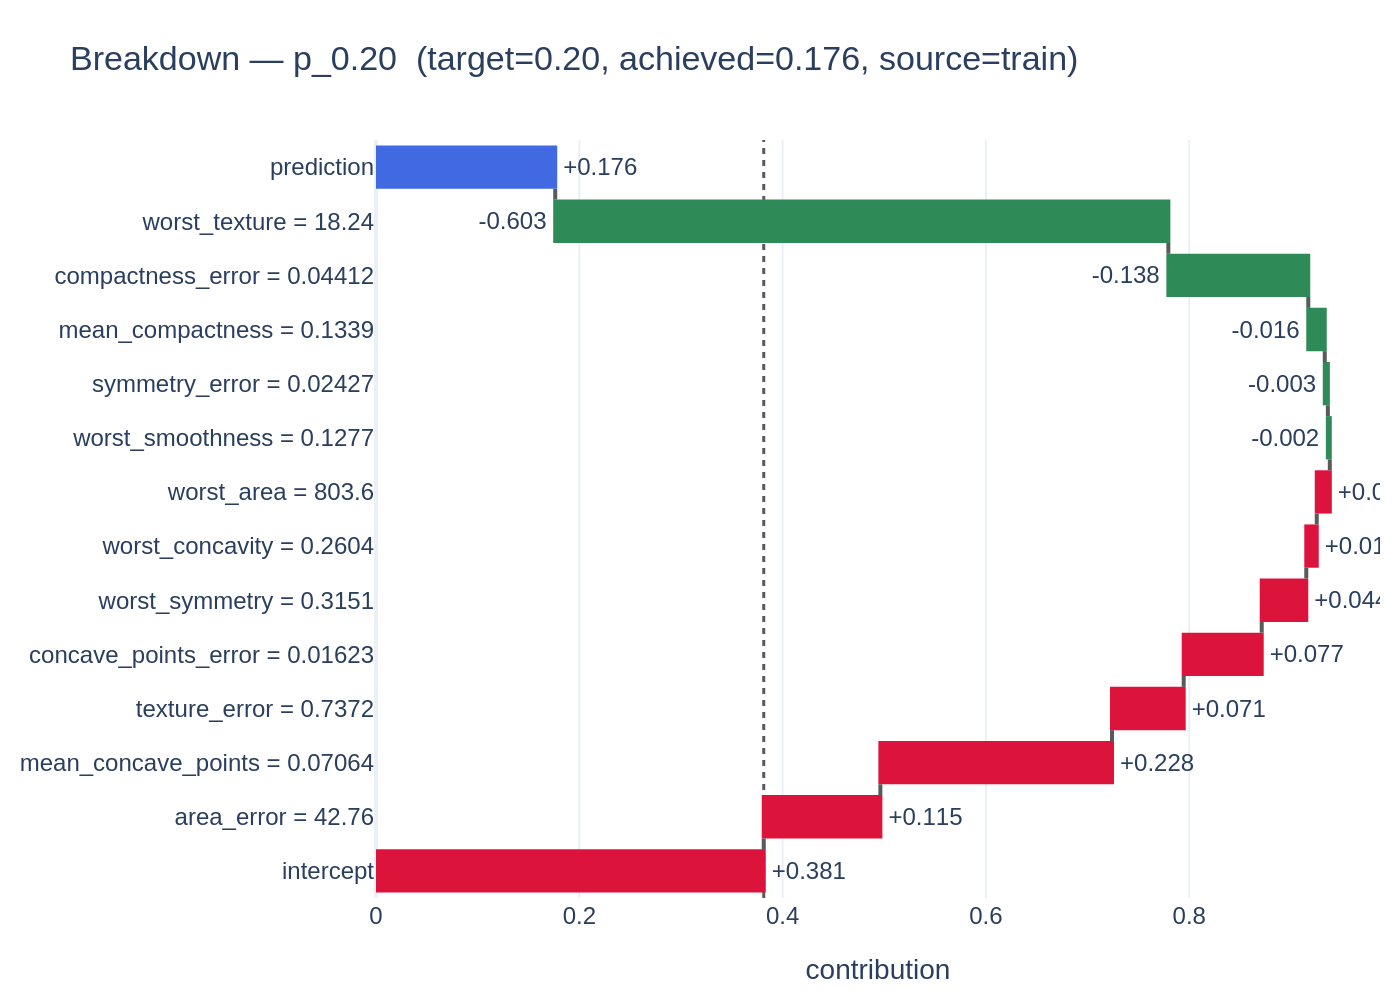

In [9]:
# Break Down: prob ≈ 0.20
label = "p_0.20"
obs   = obs_for_breakdown[label]
bd    = explainer.predict_parts(new_observation=obs, type="break_down", keep_distributions=True)

meta  = selected_df[selected_df["selection_label"] == label].iloc[0]
title = (f"Breakdown — {label}  (target={meta['target_p']:.2f}, "
         f"achieved={meta['achieved_p']:.3f}, source={meta['source']})")

print(bd.result[["variable","variable_value","contribution","cumulative"]])

# Gera figura (sem exibir interativo)
fig = plot_breakdown_from_bd(bd, title=title)

# Caminho e pasta de saída
fig_dir = Path("figures")
fig_dir.mkdir(parents=True, exist_ok=True)
png_path = fig_dir / f"breakdown_{label}.png"

# Salva PNG estático e exibe no notebook
try:
    pio.write_image(fig, str(png_path), scale=2)  # precisa do pacote 'kaleido'
    display(Image(filename=str(png_path)))
except Exception as e_img:
    print(f"Aviso: não foi possível salvar/mostrar PNG (kaleido): {type(e_img).__name__}: {e_img}")
    print("Instale com: pip install -U kaleido")


### 🔍 Breakdown — amostra **p_0.20** (prob. final ≈ **0,176**)

**Resumo em uma frase:** havia um forte acúmulo de evidências pró-maligno (subiu até ~**0,94**), mas **duas variáveis puxaram muito para baixo** — principalmente **`worst_texture`** (muito baixa) e, em menor grau, **`compactness_error`** — levando a probabilidade final para ~**0,20** (benigno).


**Subidas iniciais (pró-Maligno)**

* **Intercepto → 0,381** (ponto de partida).
* **`area_error = 42.76` (+0,115)**: eleva o risco — erros de área maiores costumam indicar irregularidade.
* **`mean_concave_points = 0.0706` (+0,228)**: forte empurrão; mais *concave points* médios associam-se a malignidade.
* **`texture_error = 0.737` (+0,071)** e **`concave_points_error = 0.0162` (+0,077)**: reforçam o movimento de alta.
* **`worst_symmetry = 0.315` (+0,044)** e **`worst_concavity = 0.260` (+0,010)**: contribuições positivas adicionais.
* **`worst_area = 804` (+0,013)**: "pior área" elevada também puxa para cima.

**Freios (pró-Benigno) — virada para baixo**

* **`compactness_error = 0.044` (−0,138)** e **`mean_compactness = 0.134` (−0,016)**: erros/níveis de *compactness* atenuam o risco acumulado.
* **`worst_texture = 18.24` (−0,603)**: **ponto de inflexão** — valor baixo de *worst texture* derruba o score e domina o balanço final.
* Pequenos ajustes negativos: **`worst_smoothness = 0.128` (−0,002)** e **`symmetry_error = 0.024` (−0,003)**.

### Por que termina em ~0,176?

Apesar de vários sinais pró-malignidade (principalmente **`mean_concave_points`** e **`area_error`**), a combinação **`compactness_error`** moderado e, sobretudo, **`worst_texture` muito baixo** **supera** os empurrões positivos. O resultado final fica **abaixo de 0,2**, classificando como **Benigno** nesse limiar.

                           variable variable_value  contribution  cumulative
0                         intercept                     0.381416    0.381416
1             worst_texture = 30.25          30.25      0.077719    0.459135
2       compactness_error = 0.01102        0.01102      0.061721    0.520856
3        mean_compactness = 0.06031        0.06031      0.041990    0.562845
4            texture_error = 0.8265         0.8265      0.030110    0.592956
5           symmetry_error = 0.0138         0.0138      0.026824    0.619780
6           worst_symmetry = 0.2994         0.2994      0.027321    0.647101
7                worst_area = 787.9          787.9      0.035904    0.683005
8          worst_concavity = 0.2085         0.2085      0.028877    0.711883
9         worst_smoothness = 0.1094         0.1094     -0.022050    0.689832
10  concave_points_error = 0.006881       0.006881     -0.037808    0.652024
11               area_error = 20.53          20.53      0.018274    0.670298

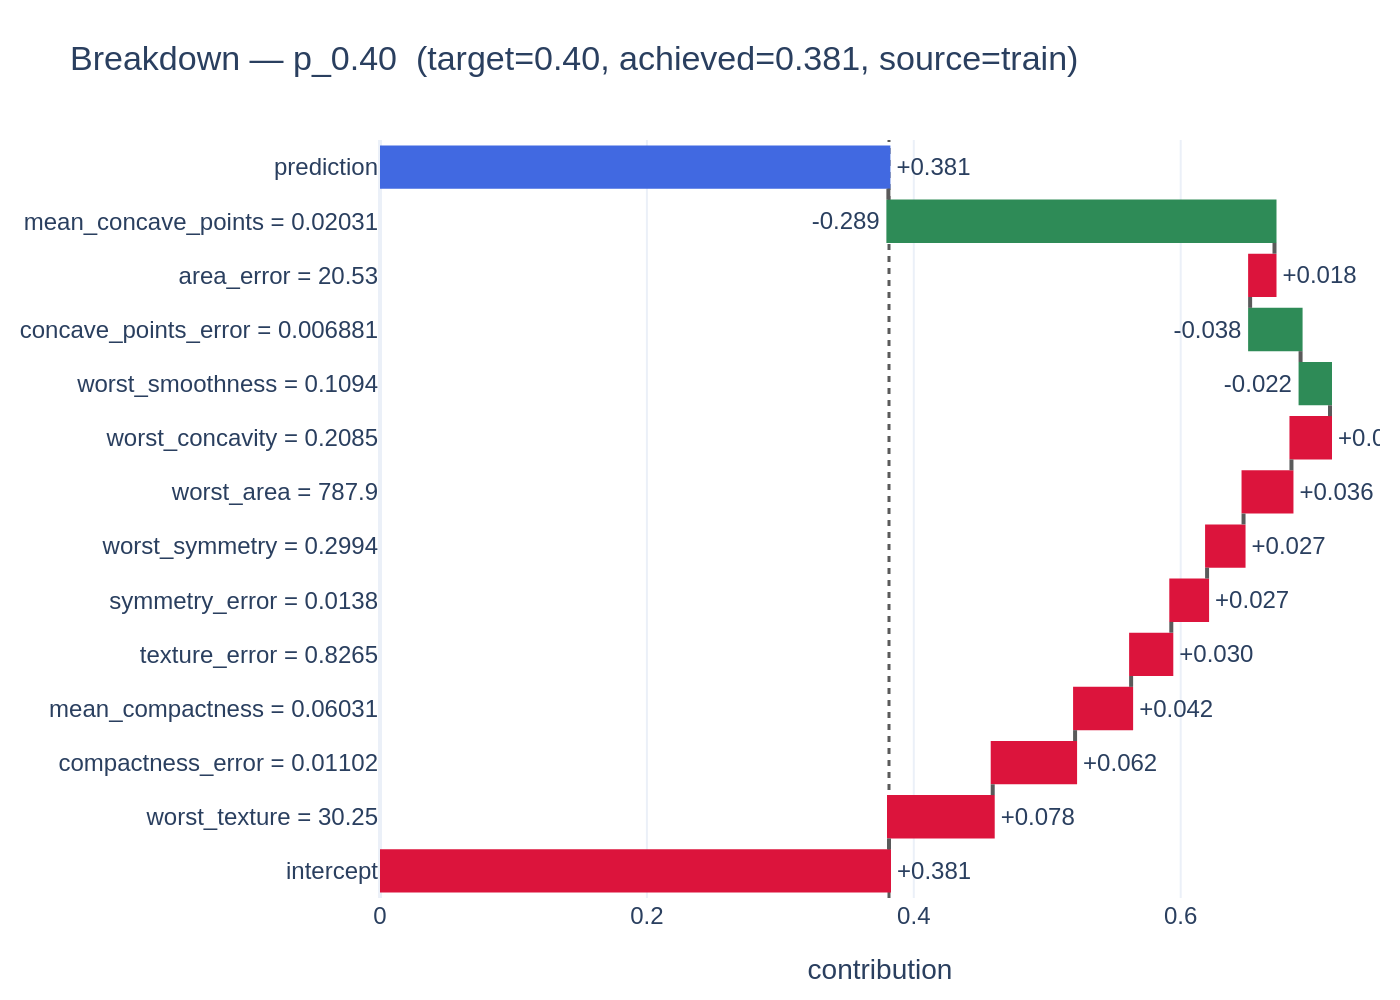

In [10]:
# Break Down: prob ≈ 0.40
label = "p_0.40"
obs   = obs_for_breakdown[label]
bd    = explainer.predict_parts(new_observation=obs, type="break_down", keep_distributions=True)

meta  = selected_df[selected_df["selection_label"] == label].iloc[0]
title = (f"Breakdown — {label}  (target={meta['target_p']:.2f}, "
         f"achieved={meta['achieved_p']:.3f}, source={meta['source']})")

print(bd.result[["variable","variable_value","contribution","cumulative"]])

# Gera figura (sem exibir interativo)
fig = plot_breakdown_from_bd(bd, title=title)

# Caminho e pasta de saída
fig_dir = Path("figures")
fig_dir.mkdir(parents=True, exist_ok=True)
png_path = fig_dir / f"breakdown_{label}.png"

# Salva PNG estático e exibe no notebook
try:
    pio.write_image(fig, str(png_path), scale=2)  # precisa do pacote 'kaleido'
    display(Image(filename=str(png_path)))
except Exception as e_img:
    print(f"Aviso: não foi possível salvar/mostrar PNG (kaleido): {type(e_img).__name__}: {e_img}")
    print("Instale com: pip install -U kaleido")


### 🔍 Breakdown — amostra **p_0.40** (prob. final ≈ **0,381**)

**Panorama:** o caso começa no **intercepto (0,381)** e recebe vários **empurrões pró-Maligno** moderados — porém termina praticamente **onde começou** porque um único fator puxa fortemente para baixo no final.

**Principais vetores de alta (↑ risco):**

* **`worst_texture = 30.25` (+0,078)**: textura "pior caso" em faixa intermediária–alta eleva o score.
* **`compactness_error = 0.011` (+0,062)** e **`mean_compactness = 0.060` (+0,042)**: irregularidade/compactação empurram para cima.
* **`texture_error = 0.827` (+0,030)**, **`symmetry_error = 0.0138` (+0,027)**, **`worst_symmetry = 0.299` (+0,027)**: reforços positivos, porém pequenos.
* **`worst_area = 788` (+0,036)** e **`worst_concavity = 0.209` (+0,029)**: medidas de "pior caso" acima de valores típicos de benignos somam ao risco.
* **`area_error = 20.53` (+0,018)**: contribuição menor, mas no sentido pró-Maligno.

**Freios (↓ risco):**

* **`worst_smoothness = 0.109` (−0,022)** e **`concave_points_error = 0.0069` (−0,038)**: atenuam parte do ganho acumulado.
* **Ponto decisivo:** **`mean_concave_points = 0.0203` (−0,289)** — valor **baixo** de *mean concave points* produz **forte queda** no score e praticamente "anula" os incrementos anteriores, fechando em **≈0,381**.

**Leitura final:**
Apesar de múltiplos sinais pró-malignidade, o **baixo `mean_concave_points`** domina o balanço local e **ancora a probabilidade em ~0,38**, muito próxima ao intercepto. No **threshold 0,50 (padrão)**, este caso é **classificado como Benigno**.



                          variable variable_value  contribution  cumulative
0                        intercept                     0.381416    0.381416
1         worst_concavity = 0.4636         0.4636      0.057869    0.439285
2    mean_concave_points = 0.05602        0.05602      0.107912    0.547197
3           worst_symmetry = 0.363          0.363      0.098472    0.645669
4            worst_texture = 26.93          26.93      0.091197    0.736866
5   concave_points_error = 0.01435        0.01435      0.076151    0.813017
6         worst_smoothness = 0.146          0.146      0.024229    0.837246
7               worst_area = 750.1          750.1      0.035658    0.872903
8            texture_error = 1.194          1.194     -0.001292    0.871611
9         symmetry_error = 0.01939        0.01939      0.000340    0.871951
10     compactness_error = 0.03438        0.03438     -0.081902    0.790049
11       mean_compactness = 0.1517         0.1517     -0.186471    0.603578
12          

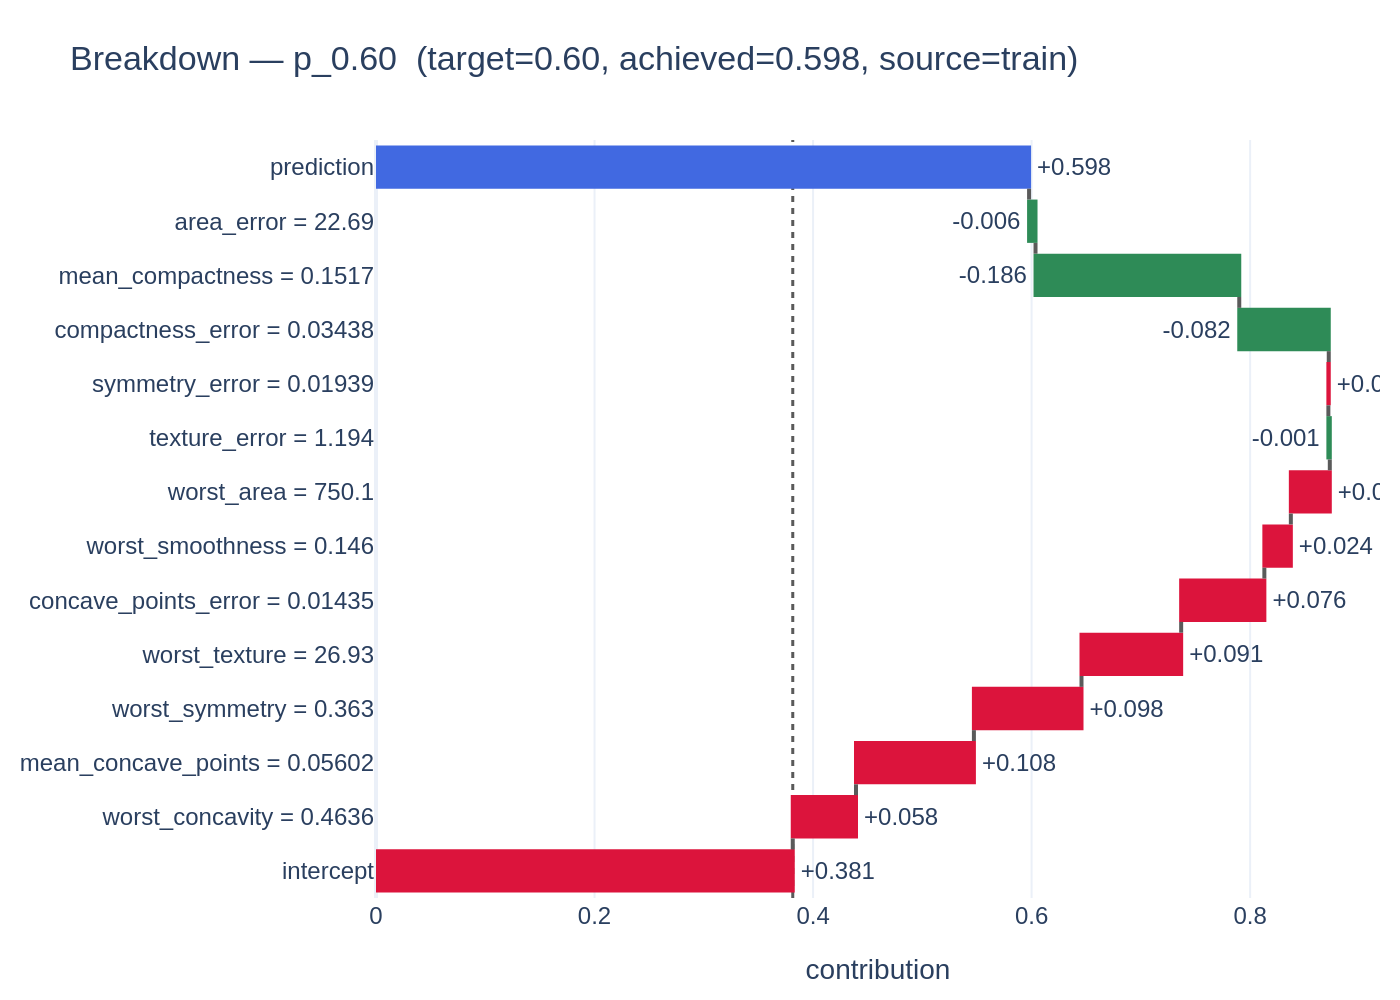

In [11]:
# Break Down: prob ≈ 0.60
label = "p_0.60"
obs   = obs_for_breakdown[label]
bd    = explainer.predict_parts(new_observation=obs, type="break_down", keep_distributions=True)

meta  = selected_df[selected_df["selection_label"] == label].iloc[0]
title = (f"Breakdown — {label}  (target={meta['target_p']:.2f}, "
         f"achieved={meta['achieved_p']:.3f}, source={meta['source']})")

print(bd.result[["variable","variable_value","contribution","cumulative"]])

# Gera figura (sem exibir interativo)
fig = plot_breakdown_from_bd(bd, title=title)

# Caminho e pasta de saída
fig_dir = Path("figures")
fig_dir.mkdir(parents=True, exist_ok=True)
png_path = fig_dir / f"breakdown_{label}.png"

# Salva PNG estático e exibe no notebook
try:
    pio.write_image(fig, str(png_path), scale=2)  # precisa do pacote 'kaleido'
    display(Image(filename=str(png_path)))
except Exception as e_img:
    print(f"Aviso: não foi possível salvar/mostrar PNG (kaleido): {type(e_img).__name__}: {e_img}")
    print("Instale com: pip install -U kaleido")


### 🔍 Breakdown — amostra **p_0.60** (prob. final ≈ **0,598**)

**Trajetória geral:** partimos do **intercepto (0,381)** e acumulamos **vários empurrões pró-Maligno** até ~**0,873**; no fim, **dois freios relevantes** derrubam o score para ~**0,60**, ainda **acima de 0,50**.

**Principais forças que **aumentam** o risco (barras vermelhas):**

* **`worst_concavity = 0.4636`** **(+0,058)** — concavidade "pior caso" alta, forte sinal morfológico de malignidade.
* **`mean_concave_points = 0.056`** **(+0,108)** — presença de pontos côncavos em média eleva substancialmente o risco.
* **`worst_symmetry = 0.363`** **(+0,098)** — simetria pior-caso elevada, mais um indício de padrão irregular.
* **`worst_texture = 26.93`** **(+0,091)** — textura no "pior caso" em faixa alta empurra o score.
* **`concave_points_error = 0.014`** **(+0,076)** — variação em pontos côncavos também colabora para o aumento.
* **`worst_smoothness = 0.146`** **(+0,024)** e **`worst_area = 750.1`** **(+0,036)** — reforços adicionais pró-Maligno.

**Ajustes pequenos / neutros:**

* **`texture_error = 1.194`** (~0) e **`symmetry_error = 0.019`** (~0) têm efeito marginal neste caso.

**Freios que **reduzem** o risco (barras verdes):**

* **`compactness_error = 0.034`** **(−0,082)** — neste regime, maior "erro" de compacidade atua como amortecedor.
* **`mean_compactness = 0.152`** **(−0,186)** — **principal queda**: valores altos de compacidade média, **condicionais** às variáveis "worst", tendem a puxar para o lado benigno no nosso LR_L2.
* **`area_error = 22.69`** **(−0,006)** — ajuste fino, pequeno.

**Leitura final:** mesmo com dois freios relevantes no fim, o conjunto de sinais fortes em **"pior caso"** (**worst_concavity**, **worst_texture**, **worst_symmetry**) e em **concavidade** (**mean_concave_points**) mantém a probabilidade em **~0,60**, **acima do limiar 0,50**, logo **classificado como Maligno**.

                          variable variable_value  contribution  cumulative
0                        intercept                     0.381416    0.381416
1            worst_texture = 32.29          32.29      0.111739    0.493156
2      compactness_error = 0.01172        0.01172      0.058129    0.551285
3       mean_compactness = 0.07214        0.07214      0.018088    0.569373
4               worst_area = 826.4          826.4      0.030659    0.600032
5   concave_points_error = 0.01269        0.01269      0.034325    0.634356
6               area_error = 27.41          27.41      0.127278    0.761634
7          worst_symmetry = 0.2722         0.2722      0.016814    0.778448
8          symmetry_error = 0.0187         0.0187      0.002959    0.781407
9            texture_error = 1.385          1.385     -0.038574    0.742833
10        worst_smoothness = 0.106          0.106     -0.039545    0.703288
11        worst_concavity = 0.1611         0.1611      0.021085    0.724373
12   mean_co

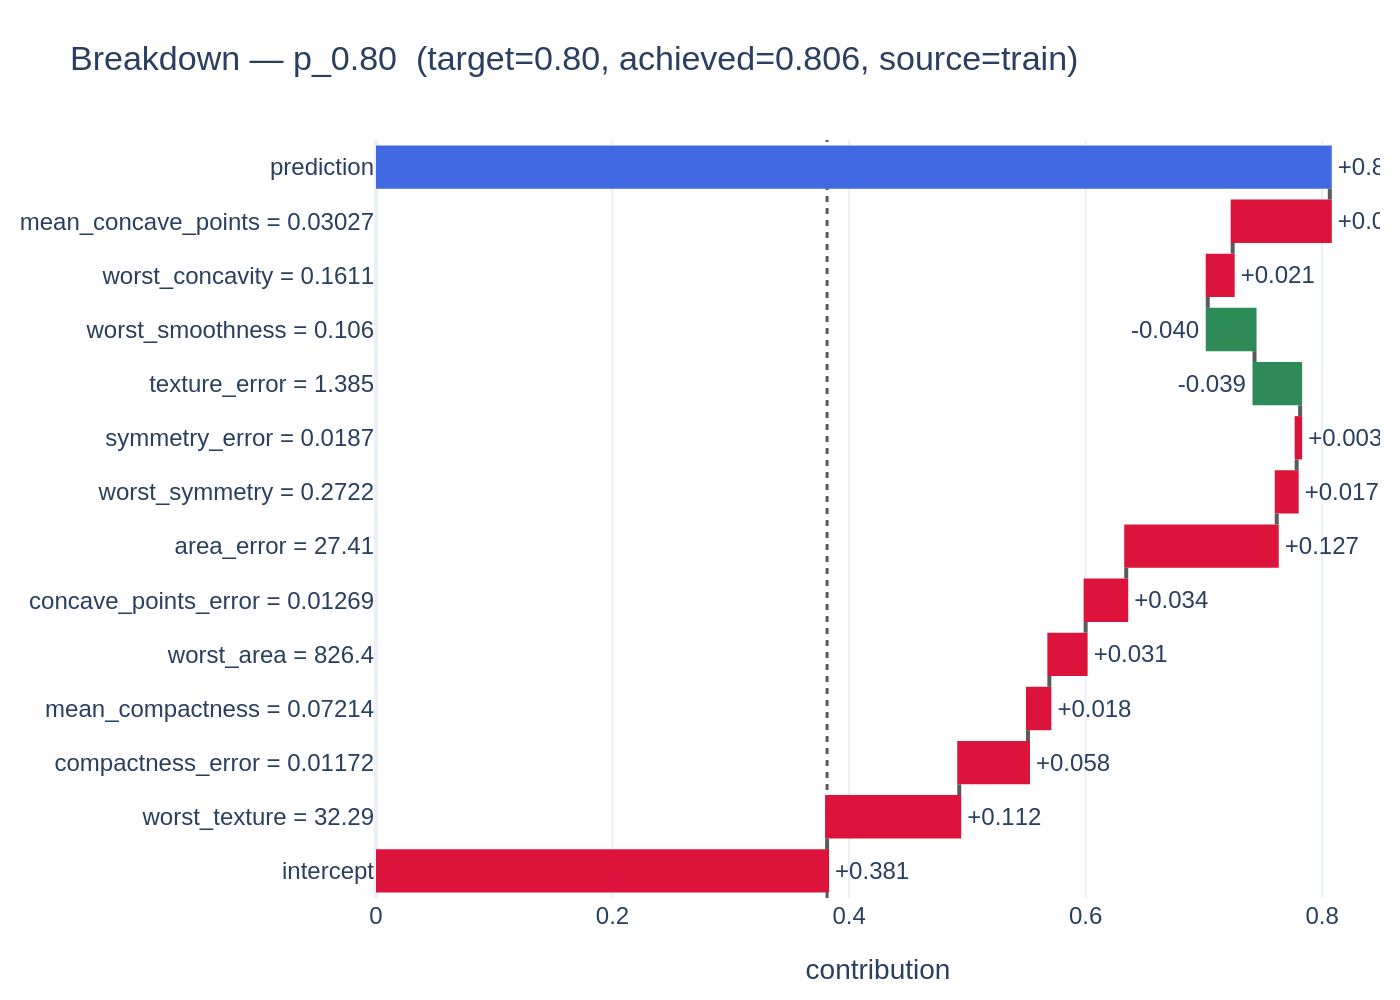

In [12]:
# Break Down: prob ≈ 0.80
label = "p_0.80"
obs   = obs_for_breakdown[label]
bd    = explainer.predict_parts(new_observation=obs, type="break_down", keep_distributions=True)

meta  = selected_df[selected_df["selection_label"] == label].iloc[0]
title = (f"Breakdown — {label}  (target={meta['target_p']:.2f}, "
         f"achieved={meta['achieved_p']:.3f}, source={meta['source']})")

print(bd.result[["variable","variable_value","contribution","cumulative"]])

# Gera figura (sem exibir interativo)
fig = plot_breakdown_from_bd(bd, title=title)

# Caminho e pasta de saída
fig_dir = Path("figures")
fig_dir.mkdir(parents=True, exist_ok=True)
png_path = fig_dir / f"breakdown_{label}.png"

# Salva PNG estático e exibe no notebook
try:
    pio.write_image(fig, str(png_path), scale=2)  # precisa do pacote 'kaleido'
    display(Image(filename=str(png_path)))
except Exception as e_img:
    print(f"Aviso: não foi possível salvar/mostrar PNG (kaleido): {type(e_img).__name__}: {e_img}")
    print("Instale com: pip install -U kaleido")


### 🔍 Breakdown — amostra **p_0.80** (prob. final ≈ **0,806**)

**O que empurrou para cima (pró-Maligno):**

* **`area_error = 27.41`** **(+0,127)** — maior variação de área está entre os **maiores impulsos** de risco.
* **`worst_texture = 32.29`** **(+0,112)** — textura no pior caso alta é um forte indício de malignidade.
* **`mean_concave_points = 0.030`** **(+0,082)** — presença média de pontos côncavos eleva significativamente a probabilidade.
* **`compactness_error = 0.0117`** **(+0,058)** e **`worst_area = 826.4`** **(+0,031)** — reforços adicionais, coerentes com morfologia mais agressiva.
* Incrementos menores, mas no mesmo sentido:
  **`concave_points_error = 0.0127`** **(+0,034)**, **`worst_symmetry = 0.272`** **(+0,017)**,
  **`worst_concavity = 0.161`** **(+0,021)**, **`symmetry_error = 0.0187`** **(+0,003)**.

**O que freou (pró-Benigno):**

* **`worst_smoothness = 0.106`** **(−0,040)** e **`texture_error = 1.385`** **(−0,039)** — amortecem um pouco o score, mas **não** mudam o desfecho.

**Leitura final:** partindo do **intercepto (0,381)**, a combinação de **textura/área no pior caso elevadas** e **medidas de concavidade** empurra o score para **~0,81** — **bem acima de 0,50**, portanto **classificado como Maligno**.

                          variable variable_value  contribution  cumulative
0                        intercept                 3.814162e-01    0.381416
1               area_error = 199.7          199.7  4.250201e-01    0.806436
2            worst_texture = 47.16          47.16  1.833300e-01    0.989766
3    mean_concave_points = 0.08646        0.08646  1.022608e-02    0.999992
4              worst_area = 3432.0         3432.0  7.568126e-06    1.000000
5      compactness_error = 0.01478        0.01478 -1.835081e-07    1.000000
6         worst_concavity = 0.3442         0.3442  2.305173e-07    1.000000
7         symmetry_error = 0.01367        0.01367  1.763440e-09    1.000000
8        worst_smoothness = 0.1401         0.1401  3.692027e-10    1.000000
9          worst_symmetry = 0.2868         0.2868  7.554923e-11    1.000000
10       mean_compactness = 0.1143         0.1143 -1.248649e-10    1.000000
11  concave_points_error = 0.00928        0.00928  1.202322e-10    1.000000
12          

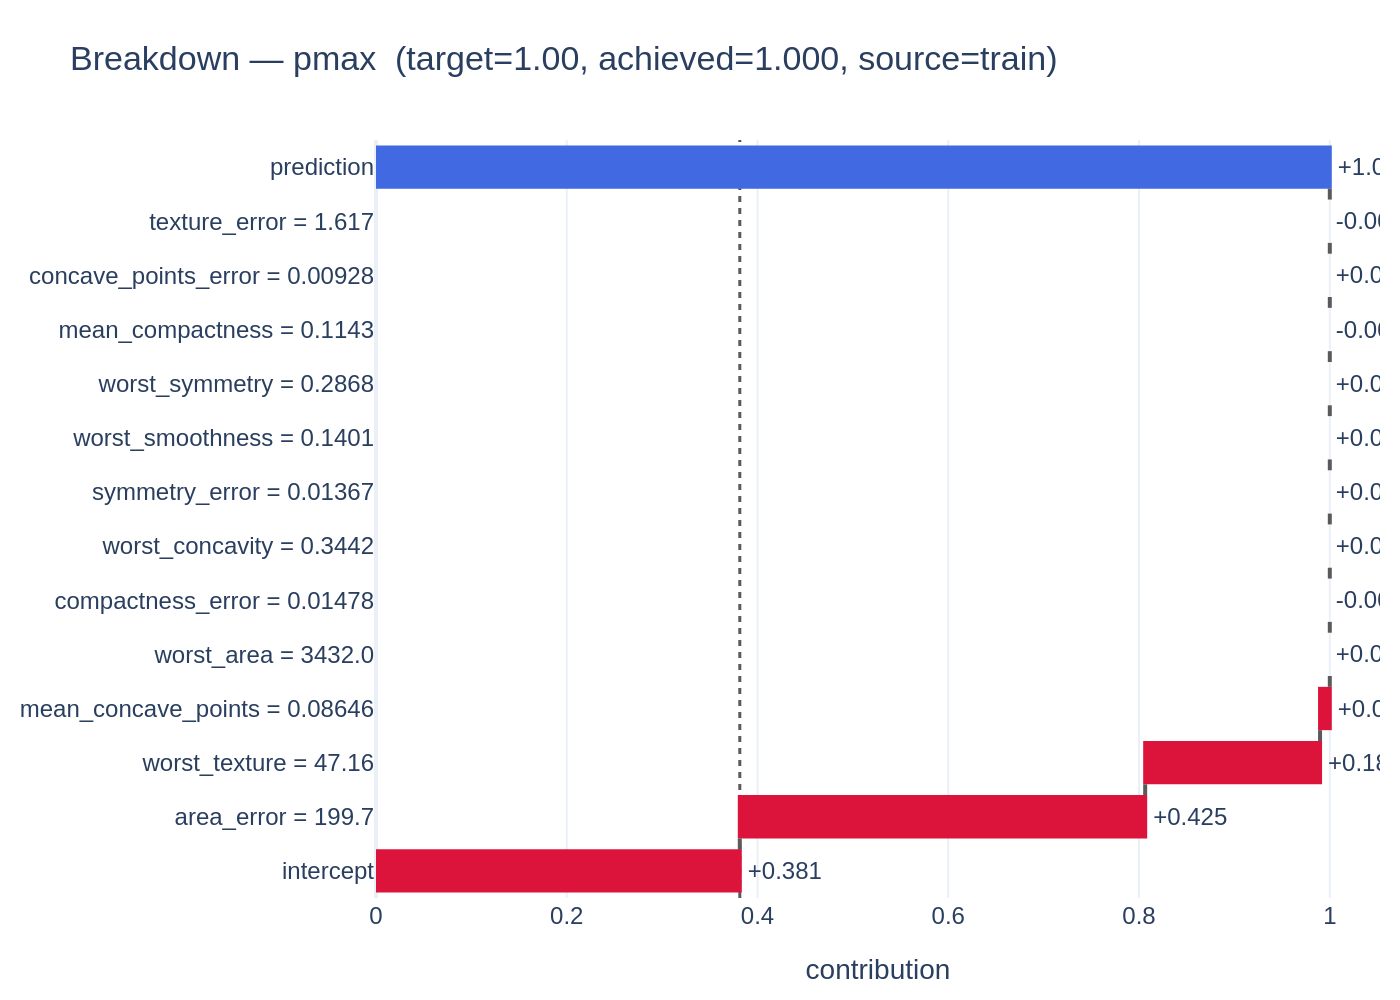

In [13]:
# Break Down: prob ≈ 1.00 (pmax)
label = "pmax"
obs   = obs_for_breakdown[label]
bd    = explainer.predict_parts(new_observation=obs, type="break_down", keep_distributions=True)

meta  = selected_df[selected_df["selection_label"] == label].iloc[0]
title = (f"Breakdown — {label}  (target={meta['target_p']:.2f}, "
         f"achieved={meta['achieved_p']:.3f}, source={meta['source']})")

print(bd.result[["variable","variable_value","contribution","cumulative"]])

# Gera figura (sem exibir interativo)
fig = plot_breakdown_from_bd(bd, title=title)

# Caminho e pasta de saída
fig_dir = Path("figures")
fig_dir.mkdir(parents=True, exist_ok=True)
png_path = fig_dir / f"breakdown_{label}.png"

# Salva PNG estático e exibe no notebook
try:
    pio.write_image(fig, str(png_path), scale=2)  # precisa do pacote 'kaleido'
    display(Image(filename=str(png_path)))
except Exception as e_img:
    print(f"Aviso: não foi possível salvar/mostrar PNG (kaleido): {type(e_img).__name__}: {e_img}")
    print("Instale com: pip install -U kaleido")


### 🔍 Breakdown — amostra **pmax** (prob. final ≈ **1.000**)

**Impulsos decisivos (pró-Maligno):**

* **`area_error = 199.7`** **(+0.425)** → é o **maior motor** do caso. Variação de área extremamente alta empurra o score de **0.38 → 0.81** sozinha.
* **`worst_texture = 47.16`** **(+0.183)** → textura no pior caso **muito elevada** leva o score de **0.81 → 0.99**.
* **`mean_concave_points = 0.0865`** **(+0.010)** → pequeno empurrão adicional para ~**1.00**.
* **`worst_area = 3432.0`** **(+7.6e-06)** → valor **extremo**, porém já em zona de saturação do modelo; contribui marginalmente porque a probabilidade já está no teto.

**Ajustes residuais (quase nulos):**

* **`compactness_error = 0.0148`** (−1.8e-07), **`worst_concavity = 0.344`** (+2.3e-07),
  **`symmetry_error = 0.0137`** (+1.8e-09), **`worst_smoothness = 0.140`** (+3.7e-10),
  **`worst_symmetry = 0.287`** (+7.6e-11), **`mean_compactness = 0.114`** (−1.2e-10),
  **`concave_points_error = 0.0093`** (+1.2e-10), **`texture_error = 1.617`** (−4.9e-12).
  Esses termos aparecem, mas o efeito é **irrelevante** pois o score já colou em **1.00**.

**Leitura final:** a combinação **muito extrema** de **variação de área** e **textura no pior caso** faz o modelo **saturar** (probabilidade ≈ **1.0**). Os demais preditores têm influência residual porque, na escala logística, **incrementos adicionais após ~0.99 quase não movem** a probabilidade.

**Intuição clínica/modelo:** padrões morfológicos **muito irregulares e heterogêneos** (grande **erro/variação de área** e **textura** no pior cenário) são fortemente associados a malignidade; aqui, esses sinais são tão expressivos que dominam completamente a decisão.


### ✅ Conclusões

Encerramos este notebook de **explicabilidade** mostrando como o *pipeline* **LR L2 + MoreStable12** toma decisões para casos individuais usando **DALEx** (Permutation Importance, PDPs/ICE e Break Down):

**O que aprendemos**

* **Coerência global vs. local**: as variáveis destacadas globalmente (Permutation Importance) também aparecem, com frequência, como motores locais nos *breakdowns*.
* **Direções consistentes**: sinais dos **coeficientes da LR** e efeitos nos **PDPs** alinham-se com as contribuições locais — p.ex., valores altos de *worst_texture*, *worst_area* e *area_error* empurram a probabilidade para **Maligno**.
* **Saturação do risco**: em casos extremos (*pmin/pmax*), contribuições finais tendem a ser residuais — o risco já está quase decidido antes das últimas variáveis entrarem.
* **Sensibilidade local**: alguns casos no "meio" da escala (p.ex., ~0.4–0.6) evidenciam **trade-offs**: pequenas variações em *mean_concave_points*, *worst_concavity* ou *area_error* podem alterar a decisão final.

**Boas práticas e limites**

* **Permutation Importance ≠ coeficiente**: a importância por permutação mede **impacto no desempenho** ao perturbar a variável; coeficientes medem o **peso linear** no modelo. Divergências são esperadas, sobretudo quando há correlação entre preditores.
* **Amostras sintéticas**: quando usadas para cobrir extremos, servem ao entendimento, mas podem exibir padrões pouco prováveis no mundo real — interpretá-las com parcimônia.
* **Explicações são condicionais**: *breakdowns* dependem do ponto do espaço; não substituem uma análise global.

**Como usar no dia a dia**

* **Auditoria de decisões**: Break Down para casos críticos (falsos negativos/positivos), registrando as principais contribuições.
* **Melhoria contínua**: monitorar se a importância relativa muda com dados novos (deriva).
* **Suporte clínico**: usar gráficos (PDP/ICE) como material de discussão para validar se os efeitos aprendidos fazem sentido clínico.

> Em resumo, o modelo está **explicável e consistente**: as variáveis do **MoreStable12** exercem efeitos alinhados ao conhecimento do domínio e às métricas. As visualizações aqui reunidas fornecem uma base sólida para **confiança**, **auditoria** e **comunicação** com stakeholders clínicos e técnicos.